# Siamese Neural Network

A *siamese network* is a network consisting in two identical (hence the name) neural networks with tied weights (the weights of the two networks are the same). Given two inputs $X_1$ and $X_2$, $X_1$ is fed to the first network and $X_2$ to the second network. Then, the outputs from the two networks are combined and produce an answer to the question: **are the two inputs similar or different?**

For more details regarding siamese networks, we refer the interested reader to the paper that introduced siamese networks in 1993: *Signature Verification using a "Siamese" Time Delay Neural Network* (Bromley and Le Cun).

<img src="https://i.stack.imgur.com/GJXrz.png" alt="Drawing" style="width: 450px;"/>

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))

Training on GPU


Let's load the MNIST data set and create pairs of similar and dissimilar images.

In [3]:
train_data = torchvision.datasets.MNIST(root='../data/', train=True, download=True)
test_data = torchvision.datasets.MNIST(root='../data/', train=False, download=True)

In [4]:
def make_pairs(data, labels, num=1000):
    digits = {}
    for i, j in enumerate(labels):
        if not j in digits:
            digits[j] = []
        digits[j].append(i)

    pairs, labels_ = [], []
    for i in range(num):
        if np.random.rand() >= .5: # same digit
            digit = np.random.choice(range(10))
            d1, d2 = np.random.choice(digits[digit], size=2, replace=False)
            labels_.append(1)
        else:
            digit1, digit2 = np.random.choice(range(10), size=2, replace=False)
            d1, d2 = np.random.choice(digits[digit1]), np.random.choice(digits[digit2])
            labels_.append(0)
        pairs.append(torch.cat([data[d1], data[d2]]).view(1, 56, 28))
    return torch.cat(pairs), torch.LongTensor(labels_)

In [5]:
batch = 100

pairs_train, labels_train = make_pairs(train_data.train_data, train_data.train_labels, num=60000)
pairs_test, labels_test = make_pairs(test_data.test_data, test_data.test_labels, num=10000)

train = torch.utils.data.dataset.TensorDataset(pairs_train, labels_train)
test = torch.utils.data.dataset.TensorDataset(pairs_test, labels_test)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch)

Now, we define the network.

In [6]:
net = torch.nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.PReLU(512),
        nn.BatchNorm1d(512),
        nn.Linear(512, 512),
        nn.PReLU(512),
        nn.BatchNorm1d(512),
        nn.Linear(512, 2)) # 2 = size of the representation (we choose 2 for visualization)


bottom_net = torch.nn.Sequential(
        nn.Linear(2, 32),
        nn.PReLU(32),
        nn.BatchNorm1d(32),
        nn.Linear(32, 2))

net = net.type(FloatTensor)
bottom_net = bottom_net.type(FloatTensor)

We define the loss function and the optimization scheme (here **Adam**) for the neural network.

In [7]:
params = [x for x in net.parameters()] + [x for x in bottom_net.parameters()]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=params, lr=0.001)

Finally, we train the network.

In [8]:
epochs = 5
train_size = int(labels_train.size()[0])
test_size = int(labels_test.size()[0])
accuracy = 0.

for i in range(epochs):
    # train network
    for j, (images, labels) in enumerate(train_loader):
        net.train()
        bottom_net.train()
        
        i1, i2 = images.view(batch, -1).split(28 * 28, dim=1)
        i1 = Variable(i1.type(FloatTensor))
        i2 = Variable(i2.type(FloatTensor))
        labels = Variable(labels).type(LongTensor)

        net.zero_grad()
        bottom_net.zero_grad()
        output1 = net(i1)
        output2 = net(i2)
        output = bottom_net((output1 - output2) ** 2)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
            
        # test network
        if (j + 1) % 600 == 0:
            net.eval()
            bottom_net.eval()
            for k, (images, labels) in enumerate(test_loader):
                i1, i2 = images.view(batch, -1).split(28 * 28, dim=1)
                i1 = Variable(i1.type(FloatTensor))
                i2 = Variable(i2.type(FloatTensor))
                labels = Variable(labels).type(LongTensor)
                output1 = net(i1)
                output2 = net(i2)
                output = bottom_net((output1 - output2) ** 2)
                _, predicted = torch.max(output, 1)
                accuracy += torch.sum(torch.eq(predicted, labels).float()).data[0] / test_size
            print('[TEST] Epoch %i/%i [step %i/%i] accuracy: %.3f' % (i + 1, epochs, j + 1, train_size / batch, accuracy))
            accuracy = 0.

[TEST] Epoch 1/5 [step 600/600] accuracy: 0.914
[TEST] Epoch 2/5 [step 600/600] accuracy: 0.936
[TEST] Epoch 3/5 [step 600/600] accuracy: 0.947
[TEST] Epoch 4/5 [step 600/600] accuracy: 0.950
[TEST] Epoch 5/5 [step 600/600] accuracy: 0.958


Let's visualize the embeddings. We notice that the representations are pretty well separated for the different digits.

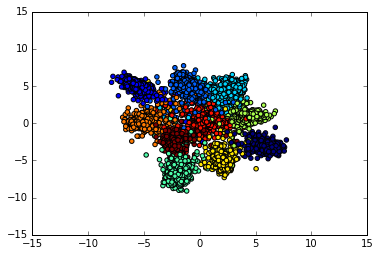

In [10]:
images = Variable(test_data.test_data).view(test_size, 28 * 28).type(FloatTensor)
labels = test_data.test_labels.numpy()
embedding = net(images).data.cpu().numpy()
plt.scatter(*zip(*embedding), c=labels)
plt.xlim(-15, 15)
plt.ylim(-15, 15);